In [13]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
# adam = adam_v2.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import cv2
from math import log10,sqrt
from PIL import Image
%matplotlib inline

In [9]:
'''
Model Construction: autoencoder, or CDAE
'''
def autoencoder():
  input_img=Input(shape=(28,28,1),name='image_input')
  #enoder 
  x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

  #decoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
  #model
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  autoencoder.summary()
  return autoencoder

def CDAE():
  input_img=Input(shape=(None,None,1),name='input_layer')
  encoding_dim_1 = 128
  encoding_dim_2 = 64
  decoding_dim_2 = encoding_dim_2
  decoding_dim_1 = encoding_dim_1
  sparsity=False
  if sparsity:
    reg = regularizers.l2(10e-5)
  else: 
    reg = None
  #enoder 
  x = Conv2D(encoding_dim_1, (3,3), activation='relu', padding='same', name='encoder_conv_1',kernel_regularizer=reg)(input_img)
  x = MaxPooling2D((2,2), padding='same', name='encoder_pool_1')(x)
  x = Conv2D(encoding_dim_2, (3,3), activation='relu', padding='same', name='encoder_conv_2',kernel_regularizer=reg)(x)
  latent_code = MaxPooling2D((2,2), padding='same', name='latent_code_layer')(x)

  #decoder
  x = Conv2D(decoding_dim_2, (3,3), activation='relu', padding='same', name='decoder_conv_1')(latent_code)
  x = UpSampling2D((2,2), name='decoder_upsample_1')(x)
  x = Conv2D(decoding_dim_1, (3,3), activation='relu', padding='same', name='decoder_conv_2')(x)
  x = UpSampling2D((2,2), name='decoder_upsample_2')(x)
  denoised_img = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='output_layer')(x)
  #model
  autoencoder = Model(inputs=input_img, outputs=denoised_img)
  encoder = Model(inputs=input_img, outputs=latent_code)

  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  autoencoder.summary()
  encoder.summary()
  return autoencoder, encoder

model, encoder=CDAE()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, None, None, 1)]   0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, None, None, 128)   1280      
_________________________________________________________________
encoder_pool_1 (MaxPooling2D (None, None, None, 128)   0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, None, None, 64)    73792     
_________________________________________________________________
latent_code_layer (MaxPoolin (None, None, None, 64)    0         
_________________________________________________________________
decoder_conv_1 (Conv2D)      (None, None, None, 64)    36928     
_________________________________________________________________
decoder_upsample_1 (UpSampli (None, None, None, 64)   

In [8]:
'''
Data preparation
'''
# read data
raw_imgs = pd.read_csv('../data/preprocess/1-raw_bmp.csv')
raw_imgs = raw_imgs.iloc[:,:].values.reshape(-1)
noisy_imgs = pd.read_csv('../data/preprocess/3-noisy_bmp.csv')
noisy_imgs = noisy_imgs.iloc[:,:].values.reshape(-1)
print('raw:', raw_imgs.shape, 'noisy:',noisy_imgs.shape)
raw_data = []
noisy_data = []
if len(noisy_imgs) < len(raw_imgs):
    for i in range(len(noisy_imgs)):
        raw_img = np.array(Image.open(raw_imgs[i]).resize((256,256),Image.LANCZOS))/ 255
        noisy_img = np.array(Image.open(noisy_imgs[i]).resize((256,256),Image.LANCZOS))/ 255
        raw_data.append(raw_img)
        noisy_data.append(noisy_img)
        # plt.imshow(image,cmap='gray')

# raw_data, (n ,None, None, 1)
raw_data = np.array(raw_data)
print('raw_data shape:',raw_data.shape)
# noisy data (n, None, None, 1)
noisy_data = np.array(noisy_data)
print('noisy_data shape:',noisy_data.shape)
'''Split into 80% train and 20% test dataset'''
total_num = raw_data.shape[0]
train_num = int(0.8*total_num)
raw_train = raw_data[:train_num] 
raw_test = raw_data[train_num:]
noisy_train = noisy_data[:train_num] 
noisy_test = noisy_data[train_num:] 
print('train scale:', raw_train.shape[0])
print('test scale:', raw_test.shape[0])

raw: (260,) noisy: (58,)
raw_data shape: (58, 256, 256)
noisy_data shape: (58, 256, 256)
train scale: 46
test scale: 12


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(raw_train, noisy_train, epochs=10, batch_size=10,validation_data=(raw_test, noisy_test), callbacks=[early_stopping])

Epoch 1/10
5/5 [==============================] - 13s 3s/step - loss: 0.6762 - val_loss: 0.6259
Epoch 2/10
5/5 [==============================] - 12s 2s/step - loss: 0.5760 - val_loss: 0.4931
Epoch 3/10
5/5 [==============================] - 12s 2s/step - loss: 0.5023 - val_loss: 0.4847
Epoch 4/10
5/5 [==============================] - 11s 2s/step - loss: 0.4900 - val_loss: 0.4899
Epoch 5/10
5/5 [==============================] - 12s 2s/step - loss: 0.4871 - val_loss: 0.4847
Epoch 6/10
5/5 [==============================] - 13s 3s/step - loss: 0.4860 - val_loss: 0.4801
Epoch 7/10
5/5 [==============================] - 11s 2s/step - loss: 0.4838 - val_loss: 0.4788
Epoch 8/10
5/5 [==============================] - 10s 2s/step - loss: 0.4825 - val_loss: 0.4784
Epoch 9/10
5/5 [==============================] - 12s 2s/step - loss: 0.4820 - val_loss: 0.4776
Epoch 10/10
5/5 [==============================] - 10s 2s/step - loss: 0.4817 - val_loss: 0.4772


In [69]:
pred = model.predict(np.random.rand(1,354,354,1))
print(pred.shape)

(1, 356, 356, 1)


In [10]:
# test
img_rand = np.random.rand(1,16,16,1)
pred_before_train = encoder.predict(img_rand)
print(pred_before_train.shape)
print(pred_before_train)
# after training
pred_before_train = encoder.predict(img_rand)
print(pred_before_train.shape)
print(pred_before_train)

(1, 4, 4, 64)
[[[[0.01501302 0.09600578 0.02295821 ... 0.07253284 0.0694368
    0.05218992]
   [0.         0.10938805 0.02413249 ... 0.09230495 0.12025043
    0.04631273]
   [0.0021054  0.08095233 0.         ... 0.0719962  0.10252042
    0.061949  ]
   [0.         0.08799984 0.         ... 0.08511876 0.09830785
    0.03206883]]

  [[0.0284171  0.12478039 0.         ... 0.09140285 0.14580013
    0.0459504 ]
   [0.00049037 0.12886341 0.         ... 0.09260084 0.10948381
    0.04271192]
   [0.         0.09428765 0.         ... 0.1045905  0.15196282
    0.06477398]
   [0.         0.10729371 0.         ... 0.07143067 0.11175463
    0.07940578]]

  [[0.         0.13522968 0.         ... 0.11333944 0.12424037
    0.03797133]
   [0.         0.11125959 0.         ... 0.09956174 0.12730707
    0.063302  ]
   [0.         0.12939264 0.         ... 0.07404501 0.12269968
    0.04058091]
   [0.         0.11487411 0.         ... 0.08913933 0.12482999
    0.03784287]]

  [[0.00516936 0.12170374 0.     

In [ ]:
'''
Model Training
'''
# if GPU available
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    CDAE.fit(raw_train, noisy_train, epochs=100, batch_size=10, validation_data=(raw_test, noisy_test), callbacks=[early_stopping,TensorBoard(log_dir=r"/data-output/DAE_test",
                        histogram_freq=1,update_freq="batch")])


In [ ]:
'''
Prediction
'''
pred_denoised_img = model.predict(noisy_test[:5])
pred_latent_code = encoder.predict(noisy_test[:5])

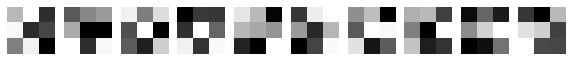

In [35]:
'''
Weights Visiualization
'''
def plot_weights_matrix(model, layer_name, n_neurons):
    """
    Plots the weight matrix of the first `n_neurons` neurons of a layer in the given model.
    
    The kernel of the given layer has dimensions input_shape x output_shape. We slice this
    matrix by the axis of the output_shape and display each of the slices reshaped to a quadratic
    picture.
    
    INPUT:
        model: A trained Keras model
        layer_name (string): name of the layer whose weight matrix shall be shown
        n_neurons (int): number of neurons to be visualized
    """
    kernel_eval = K.eval(model.get_layer(layer_name).kernel)
    
    # dimension for weight matrix plot
    # dim = int(np.sqrt(kernel_eval.T[0].shape)[0])
    dim = 3    
    # plot the first n_neurons neurons
    fig = plt.figure(figsize=(n_neurons, 4))
    for i in range(n_neurons):
        plt.subplot(1, n_neurons, i + 1)
        plt.imshow(kernel_eval.T[i].reshape(dim, dim), cmap='gray')
        plt.axis('off')
    plt.show()
plot_weights_matrix(encoder,'encoder_conv_1',10)

In [24]:
'''
Model save 
'''
def save_CDAE(model,encoder,id=None):
    save_dir_path = '../weights/'
    model_id_list = []
    if not os.path.exists(save_dir_path):
        os.mkdir(save_dir_path)
    else:
        for file_name in os.listdir(save_dir_path):
            if file_name.endswith('.h5'):
                model_id_list.append(int(file_name[-4]))
    if not id:
        id = 0
        if len(model_id_list) > 0:
            id = max(model_id_list) + 1
    save_model(model,save_dir_path + 'CDAE_model_'+str(id)+'.h5')
    save_model(encoder,save_dir_path + 'encoder_model_'+str(id)+'.h5')
save_CDAE(model,encoder,id=1)

            # print(int(file_name[-4]))
# save_model(model,save_dir_path + 'CDAE_model_test1.h5')
# save_model(encoder,save_dir_path + 'encoder_model_test1.h5')



In [18]:
encoder_test.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, None, None, 1)]   0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, None, None, 128)   1280      
_________________________________________________________________
encoder_pool_1 (MaxPooling2D (None, None, None, 128)   0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, None, None, 64)    73792     
_________________________________________________________________
latent_code_layer (MaxPoolin (None, None, None, 64)    0         
Total params: 75,072
Trainable params: 75,072
Non-trainable params: 0
_________________________________________________________________
